In [1]:
# initial setup
try:
    # settings colab:
    import google.colab
        
except ModuleNotFoundError:    
    # settings local:
    %run "common/0_notebooks_base_setup.py"

default checking
Running command `conda list`... ok
jupyterlab=1.2.6 already installed
pandas=1.0.3 already installed
matplotlib=2.2.2 already installed
bokeh=2.0.0 already installed
seaborn=0.10.0 already installed
ipywidgets=7.5.1 already installed
pytest=5.3.4 already installed
chardet=3.0.4 already installed
psutil=5.7.0 already installed
scipy=1.4.1 already installed
statsmodels=0.11.0 already installed
scikit-learn=0.22.1 already installed
xlrd=1.2.0 already installed
plotly=4.6.0 already installed
chart-studio=1.1.0 already installed
plotly-orca=1.3.1 already installed
Running command `conda install --yes unicodedata2`... ok
Solving environment: ...working... done

# All requested packages already installed.


Importando librerías ...
Las librerías has sido importadas con éxito


In [2]:
# LECTURA DEL ARCHIVO DE DATOS
data_clean = pd.read_csv("CleanCSV/Clean07_Final.csv")

In [3]:
# SÓLO PARA USO EN COMPARACIONES
data_clean_ORIGINAL = data_clean.copy(deep=True) 

In [4]:
data_clean.head(3)

,Unnamed: 0,País,Provincia,Área,Localidad,Zona,Lugar,operation,property_type,geonames_id,...,gimnasio,subte,baulera,piscina_house,piscina_depart,desc_banios,tipo_propiedad_PH,tipo_propiedad_apartment,tipo_propiedad_house,tipo_propiedad_store
0,0,Argentina,Capital Federal,Capital Federal,Mataderos,Mataderos,Mataderos,sell,PH,3430787.0,...,0.0,0.0,0.0,0,0,1.0,1,0,0,0
1,1,Argentina,Buenos Aires,Zona Sur,La Plata,La Plata,La Plata,sell,apartment,3432039.0,...,0.0,0.0,0.0,0,0,1.0,0,1,0,0
2,2,Argentina,Capital Federal,Capital Federal,Mataderos,Mataderos,Mataderos,sell,apartment,3430787.0,...,0.0,0.0,0.0,0,0,1.0,0,1,0,0


In [5]:
data_clean.columns

Index(['Unnamed: 0', 'País', 'Provincia', 'Área', 'Localidad', 'Zona', 'Lugar', 'operation', 'property_type', 'geonames_id', 'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses', 'description', 'url_clean', 'url_terraza', 'url_quincho', 'desc_terraza', 'desc_quincho', 'garage', 'lavadero', 'balcon', 'parrilla', 'jardin', 'patio', 'amenities', 'estrenar', 'gimnasio', 'subte', 'baulera', 'piscina_house', 'piscina_depart', 'desc_banios', 'tipo_propiedad_PH', 'tipo_propiedad_apartment', 'tipo_propiedad_house', 'tipo_propiedad_store'], dtype='object')

<hr id="Ubicaciones">

#### AGRUPANDO y DETECTANDO OUTLIERS (por RANGO INTERCUARTIL) en "price_usd_per_m2" y "price_aprox_usd"

In [6]:
# PRUEBA PARA ENTENDER CÓMO DEVUELVE LOS FRAME LA ITERACIÓN SOBRE EL GROUPBY 
# LOS VOY A AGRUPAR POR LOCALIDAD y POR TIPO DE PROPIEDAD PARA ELEIMINAR OUTLIERS

#grupos_x_localidad = data_clean.loc[(data_clean["Área"] == "Capital Federal")].groupby(["Localidad", "property_type"])
#for localidad, frame in grupos_x_localidad:
#    display(frame)

In [7]:
# DEFINIMOS UNA FUNCIÓN QUE ENCUENTRA EL RANGO INTERCUARTIL EN "price_usd_per_m2"
def cuartiles_price_usd_per_m2_localidad(frame_agrupado_localidad):
    q1 = frame_agrupado_localidad["price_usd_per_m2"].quantile(0.25)
    q2 = frame_agrupado_localidad["price_usd_per_m2"].quantile(0.50)
    q3 = frame_agrupado_localidad["price_usd_per_m2"].quantile(0.75)
    q4 = frame_agrupado_localidad["price_usd_per_m2"].quantile(1)
    qi = q3-q1
    qsup = q3 + (qi*1.5)
    qinf = q1 - (qi*1.5)
    qinf, qsup
    
    outlier_mask_up = (frame_agrupado_localidad["price_usd_per_m2"] > qsup)
    outlier_mask_down = (frame_agrupado_localidad["price_usd_per_m2"] < qinf)
    outlier_mask = np.logical_or(outlier_mask_up, outlier_mask_down)
    
    indices_outliers_return = list(frame_agrupado_localidad[outlier_mask].index)
    
    local_qs = (frame_agrupado_localidad["Localidad"].iloc[0], q1, q3)
    
    return indices_outliers_return, local_qs     
    

##### Outliers en "price_usd_per_m2"

In [8]:
# DETECCIÓN DE OUTLIERS EN "price_usd_per_m2" utilizando la función antes definida
# SEPARO POR PROVINCIA ("ÁREA") y LUEGO AGRUPO POR ["Localidad", "property_type"] para encontrar outliers

indices_outliers = []
localidades_qs =[]

for area_name in (data_clean["Área"].value_counts().index):
    grupos_x_localidad = data_clean.loc[(data_clean["Área"] == area_name)].groupby(["Localidad", "property_type"])
    for localidad, frame in grupos_x_localidad:
        # HACEMOS LAS OPERACIONES POR LOCALIDAD
        indices_a_eliminar, locali_qs = cuartiles_price_usd_per_m2_localidad(frame)
        indices_outliers.extend(indices_a_eliminar)
        localidades_qs.append(locali_qs)
        #display(frame)

In [9]:
localidades_qs[0:3]

[('Abasto', 1000.0, 2000.0),
 ('Abasto', 1837.962962962963, 2537.5640045543264),
 ('Abasto', 1341.362973760933, 1536.5552814532407)]

In [10]:
data_clean.shape

(121220, 43)

In [11]:
# ELIMINACIÓN DE OUTLIERS EN "price_usd_per_m2"
data_clean.drop(indices_outliers, axis=0, inplace=True)

In [12]:
data_clean.shape

(118570, 43)

##### Outliers en "price_aprox_usd"

In [13]:
# DEFINIMOS UNA FUNCIÓN QUE ENCUENTRA EL RANGO INTERCUARTIL EN "price_aprox_usd"
def cuartiles_price_aprox_usd_localidad(frame_agrupado_localidad):
    q1 = frame_agrupado_localidad["price_aprox_usd"].quantile(0.25)
    q2 = frame_agrupado_localidad["price_aprox_usd"].quantile(0.50)
    q3 = frame_agrupado_localidad["price_aprox_usd"].quantile(0.75)
    q4 = frame_agrupado_localidad["price_aprox_usd"].quantile(1)
    qi = q3-q1
    qsup = q3 + (qi*1.5)
    qinf = q1 - (qi*1.5)
    qinf, qsup
    
    outlier_mask_up = (frame_agrupado_localidad["price_aprox_usd"] > qsup)
    outlier_mask_down = (frame_agrupado_localidad["price_aprox_usd"] < qinf)
    outlier_mask = np.logical_or(outlier_mask_up, outlier_mask_down)
    
    indices_outliers_return = list(frame_agrupado_localidad[outlier_mask].index)
    
    local_qs = (frame_agrupado_localidad["Localidad"].iloc[0], q1, q3)
    
    return indices_outliers_return, local_qs     

In [14]:
# DETECCIÓN DE OUTLIERS EN "price_aprox_usd" utilizando la función antes definida
# SEPARO POR PROVINCIA ("ÁREA") y LUEGO AGRUPO POR ["Localidad", "property_type"] para encontrar outliers

#indices_outliers = []
#localidades_qs =[]

#for area_name in (data_clean["Área"].value_counts().index):
#    grupos_x_localidad = data_clean.loc[(data_clean["Área"] == area_name)].groupby(["Localidad", "property_type"])
#    for localidad, frame in grupos_x_localidad:
#        # HACEMOS LAS OPERACIONES POR LOCALIDAD
#        indices_a_eliminar, locali_qs = cuartiles_price_aprox_usd_localidad(frame)
#        indices_outliers.extend(indices_a_eliminar)
#        localidades_qs.append(locali_qs)
        #display(frame)

In [15]:
#localidades_qs[0:3]

In [16]:
data_clean.shape

(118570, 43)

In [17]:
# ELIMINACIÓN DE OUTLIERS EN "price_usd_per_m2"
#data_clean.drop(indices_outliers, axis=0, inplace=True)

In [18]:
data_clean.shape

(118570, 43)

#### GRAFICANDO POR ZONAS

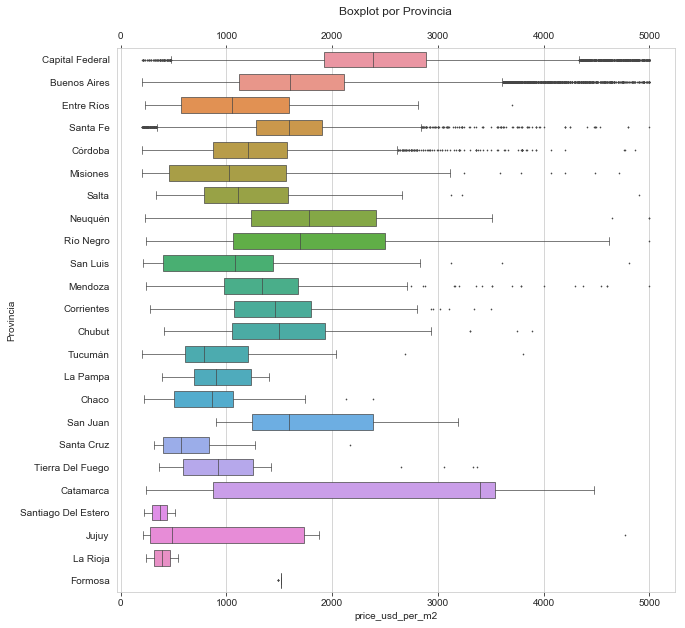

In [19]:
# boxplot POR PROVINCIA  - price_usd_per_m2 -  ANTES

sort_prov = data_clean_ORIGINAL.Provincia.unique()

fig = plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")

ax = plt.title("Boxplot por Provincia", y=1.05) # le doy un pequeño offset el título sino se superpone

ax = sns.boxplot("price_usd_per_m2", "Provincia", data= data_clean_ORIGINAL, order=sort_prov,  width=0.7, whis=1.5, fliersize=0.8, linewidth=0.7)
ax.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)

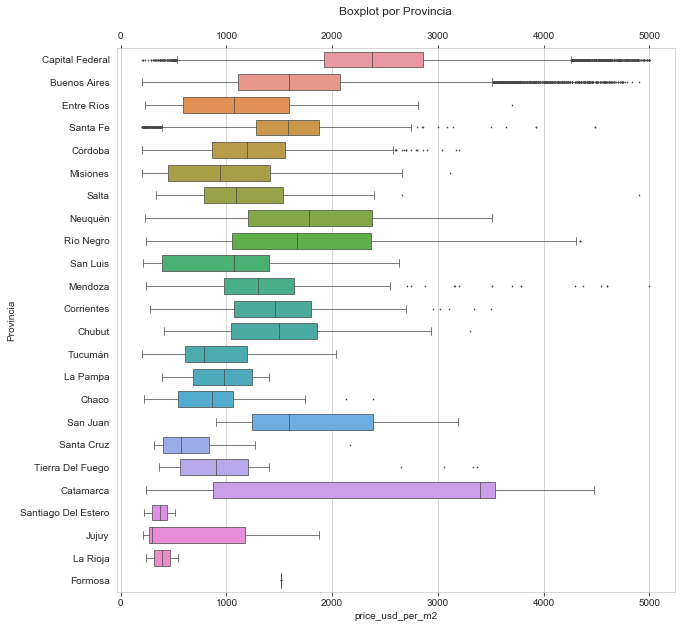

In [20]:
# boxplot POR PROVINCIA - price_usd_per_m2 - LUEGO DE ELIMINAR OUTLIERS

#sort_prov = data_clean.Provincia.unique() # ACÁ VOY A USAR EL MISMO SORT QUE ANTES, PORQUE SINO ME CAMBIA

fig = plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")

ax = plt.title("Boxplot por Provincia", y=1.05) # le doy un pequeño offset el título sino se superpone

ax = sns.boxplot("price_usd_per_m2", "Provincia", data= data_clean, order=sort_prov,  width=0.7, whis=1.5, fliersize=0.8, linewidth=0.7)
ax.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)

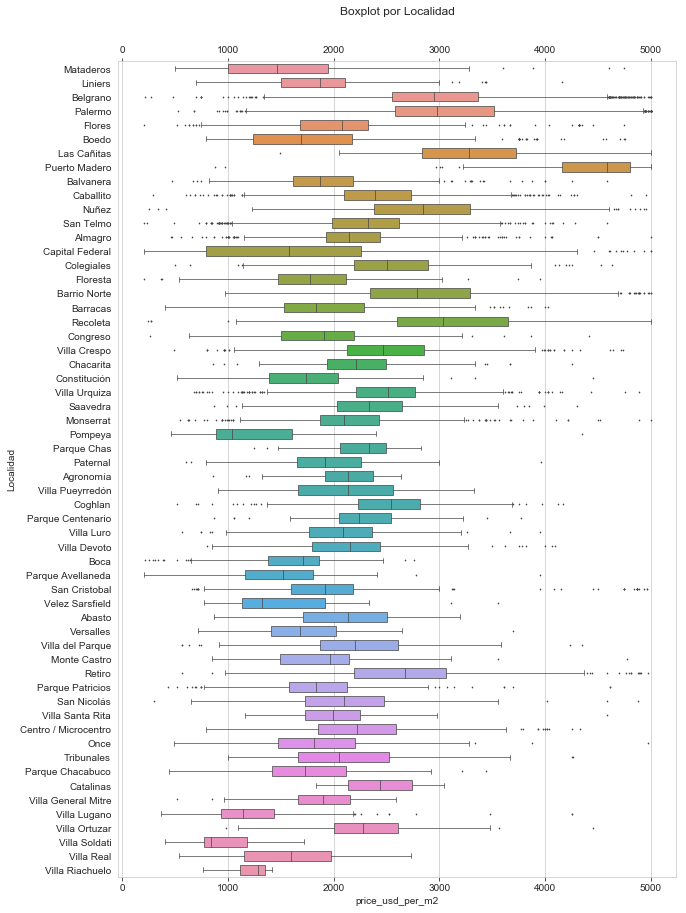

In [21]:
#from pylab import savefig  - price_usd_per_m2 -  ANTES (ejemplo sólo con CABA)

# boxplot POR LOCALIDAD - EJEMPLO: SÓLO CAPITAL FEDERAL
grupos_x_capital= data_clean_ORIGINAL.loc[(data_clean_ORIGINAL["Área"] == "Capital Federal")]

sort_local = grupos_x_capital.Localidad.unique()  

ax = plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")

ax = plt.title("Boxplot por Localidad", y=1.05) # le doy un pequeño offset el título sino se superpone

ax = sns.boxplot("price_usd_per_m2", "Localidad", data= grupos_x_capital, order=sort_local,  width=0.7, whis=1.5, fliersize=0.8, linewidth=0.7)
ax.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)

ax.figure.savefig("output_antes.png", bbox_inches='tight')


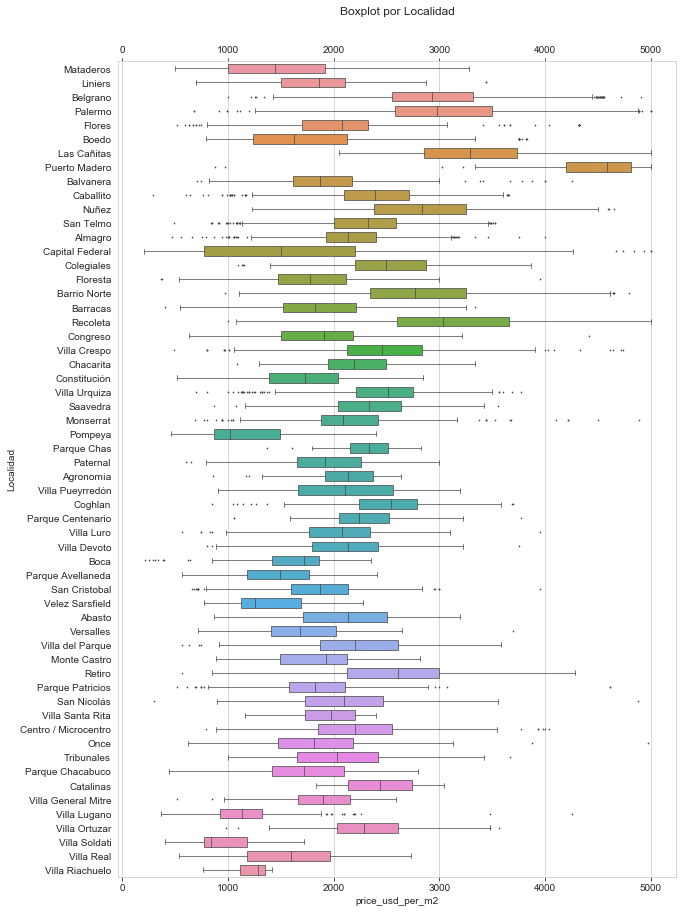

In [22]:
# boxplot POR LOCALIDAD  - price_usd_per_m2 -  LUEGO DE ELIMINAR OUTLIERS (ejemplo sólo con CABA)

grupos_x_capital= data_clean.loc[(data_clean_ORIGINAL["Área"] == "Capital Federal")]

#sort_local = grupos_x_capital.Localidad.unique() # ACÁ VOY A USAR EL MISMO SORT QUE ANTES, PORQUE SINO ME CAMBIA

fig = plt.figure(figsize=(10, 15))
sns.set_style("whitegrid")

ax = plt.title("Boxplot por Localidad", y=1.05) # le doy un pequeño offset el título sino se superpone

ax = sns.boxplot("price_usd_per_m2", "Localidad", data= grupos_x_capital, order=sort_local, width=0.7, whis=1.5, fliersize=0.8, linewidth=0.7)
ax.tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)

ax.figure.savefig("output_depues.png", bbox_inches='tight')

<hr id="ToCSV">
<h2 style="color: lightblue">GENERAR CSV FINAL</h2>

In [23]:
data_clean.to_csv("CleanCSV/Clean08_OultiersxZona.csv")